# Lithium niobate phase-shifter

Reproducing {cite}`Han2022`

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from skfem import Basis, ElementDG, ElementTriP0, ElementTriP1
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.coulomb import solve_coulomb
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

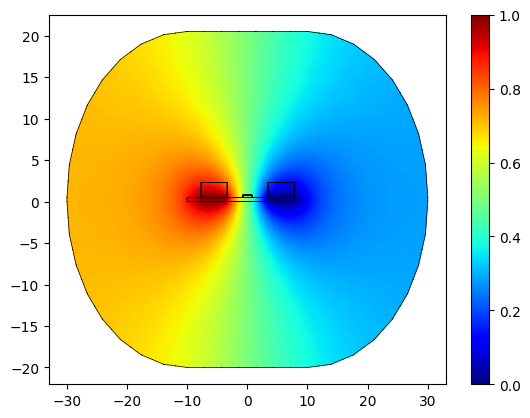

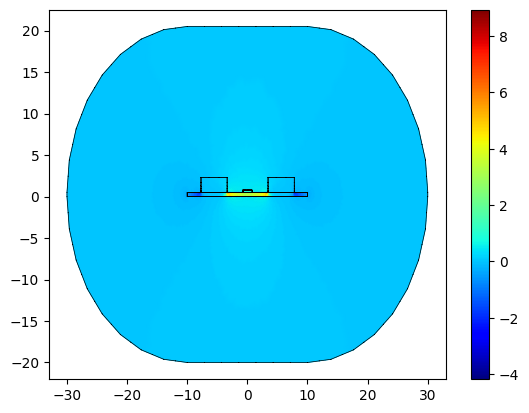

100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


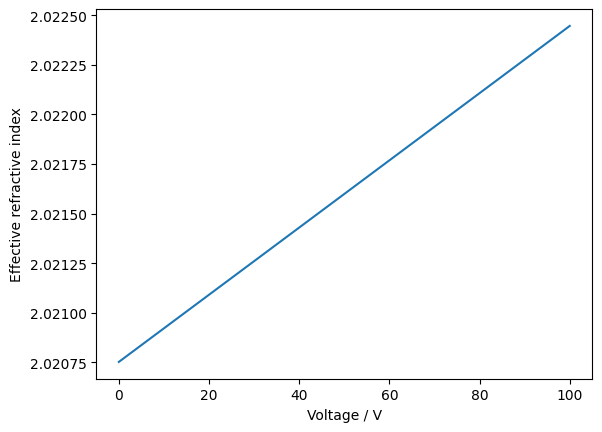

In [2]:
core_width = 1.532
electrode_start_x = core_width / 2 + 2.629
electrode_width = 4.4

electrode_left = box(-electrode_start_x - electrode_width, 0.5, -electrode_start_x, 0.5 + 1.8)
electrode_right = box(electrode_start_x, 0.5, electrode_start_x + electrode_width, 0.5 + 1.8)
slab = box(-10, 0, 10, 0.5)
core = box(-core_width / 2, 0.5, core_width / 2, 0.8)
env = slab.buffer(20, resolution=8)

polygons = OrderedDict(
    electrode_left=electrode_left,
    electrode_right=electrode_right,
    slab=slab,
    core=core,
    env=env,
)

resolutions = dict(
    slab={"resolution": 0.1, "distance": 4},
    core={"resolution": 0.1, "distance": 4},
)

mesh = from_meshio(
    mesh_from_OrderedDict(polygons, resolutions, filename="mesh.msh", default_resolution_max=3)
)

basis = Basis(mesh, ElementTriP1(), intorder=4)
basis_epsilon_r = basis.with_element(ElementTriP0())

epsilon_dc = basis_epsilon_r.zeros() + 3.9
epsilon_dc[basis_epsilon_r.get_dofs(elements="slab")] = 28.4
epsilon_dc[basis_epsilon_r.get_dofs(elements="core")] = 7.5
# basis.plot(epsilon).show()

basis_u, u = solve_coulomb(
    basis_epsilon_r,
    epsilon_dc,
    {"electrode_left___slab": 1, "electrode_right___slab": 0},
)

fig, ax = plt.subplots()
for subdomain in basis_epsilon_r.mesh.subdomains.keys() - {"gmsh:bounding_entities"}:
    basis_epsilon_r.mesh.restrict(subdomain).draw(ax=ax, boundaries_only=True)
basis_u.plot(u, ax=ax, shading="gouraud", colorbar=True)
# basis_vec.plot(-u_grad, ax=ax)
plt.show()

fig, ax = plt.subplots()
for subdomain in basis_epsilon_r.mesh.subdomains.keys() - {"gmsh:bounding_entities"}:
    basis_epsilon_r.mesh.restrict(subdomain).draw(ax=ax, boundaries_only=True)
basis_grad = basis_u.with_element(ElementDG(basis_u.elem))
e_x = basis_u.project(-basis_epsilon_r.interpolate(epsilon_dc) * basis_u.interpolate(u).grad[0])
basis_u.plot(e_x, ax=ax, shading="gouraud", colorbar=True)
plt.show()

voltages = np.linspace(0, 100, 5)
voltages_neffs = []

for voltage in tqdm(voltages):
    refractive_index_optical = basis_epsilon_r.zeros() + 1.445
    refractive_index_optical[basis_epsilon_r.get_dofs(elements="core")] = 1.989
    refractive_index_optical[basis_epsilon_r.get_dofs(elements="slab")] = (
        2.211
        + 0.5
        * 2.211**3
        * 31e-6
        * basis_epsilon_r.project(-basis_u.interpolate(u).grad[0])[
            basis_epsilon_r.get_dofs(elements="slab")
        ]
        * voltage
    )
    # basis_epsilon_r.plot(refractive_index, colorbar=True).show()

    modes = compute_modes(basis_epsilon_r, refractive_index_optical**2, wavelength=1.55)
    voltages_neffs.append(modes[0].n_eff)

    # from mode_solver import plot_mode
    # plot_mode(basis_modes, modes[0])
    # plt.show()

plt.plot(voltages, np.real(voltages_neffs))
plt.xlabel("Voltage / V")
plt.ylabel("Effective refractive index")
plt.show()

## Bibliography

```{bibliography}
:style: unsrt
:filter: docname in docnames
```